In [1]:
!pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json

country = 'uk'
main_color = 'red'
models = ['DG', 'G', 'MFG', 'NG']
rounds = ['0']

# Standard Plots

In [2]:
dfs = []
for r in rounds:
    for model in models:
        filename = 'tile2cpc_' + model + '_' + country + '_' + r + '.csv'
        df = pd.read_csv('../results/'+filename)
        df.set_index('tile', inplace=True)
        df.fillna(0, inplace=True)
        df.rename(columns={'cpc': r + '_' + model}, inplace=True)
        dfs.append(df)
    
df = dfs[0]
    
for d in dfs[1:]:
    df = df.join(d)

archive = zipfile.ZipFile('../data/'+ country + '/tileid2oa2handmade_features.json.zip', 'r')
with archive.open('tileid2oa2handmade_features.json') as f:
    tileid2oa2features2vals = json.load(f)
    
df.reset_index(inplace=True)
df = df[df['tile'] != 0]
areas = list(df['tile'].unique())
tile_sizes = []
for area in areas:
    tile_sizes.append(len(tileid2oa2features2vals[str(area)].keys()))

In [3]:
df['n_oas'] = tile_sizes

In [8]:
if country == 'ny' or country == 'ny10' or country == 'socal':
    #df = df[df.n_oas >= 3]
    df['rank_oa'] = df['n_oas'].rank(method='first')
    deciles_n_oas = pd.qcut(df['rank_oa'], q=10, labels=False)
else:
    deciles_n_oas = pd.qcut(df['n_oas'], q=10, labels=False)
df['decile_n_oas'] = deciles_n_oas

df['DG'] = df[[x + '_DG' for x in rounds]].mean(axis=1)
df['G'] = df[[x + '_G' for x in rounds]].mean(axis=1)
df['NG'] = df[[x + '_NG' for x in rounds]].mean(axis=1)
df['MFG'] = df[[x + '_MFG' for x in rounds]].mean(axis=1)
#df['DGsum'] = df[[x + '_DGsum' for x in rounds]].mean(axis=1)

df.rename(columns = {'DG': 'deep', 'G': 'original_p', 'MFG': 'original', 'NG': 'deep_p'}, inplace=True)
df = df.sort_values(by='decile_n_oas')

In [9]:
country_to_string = {
    'uk': 'England'
}

country_to_subid = {
    'uk': ['a)', 'b)']
}

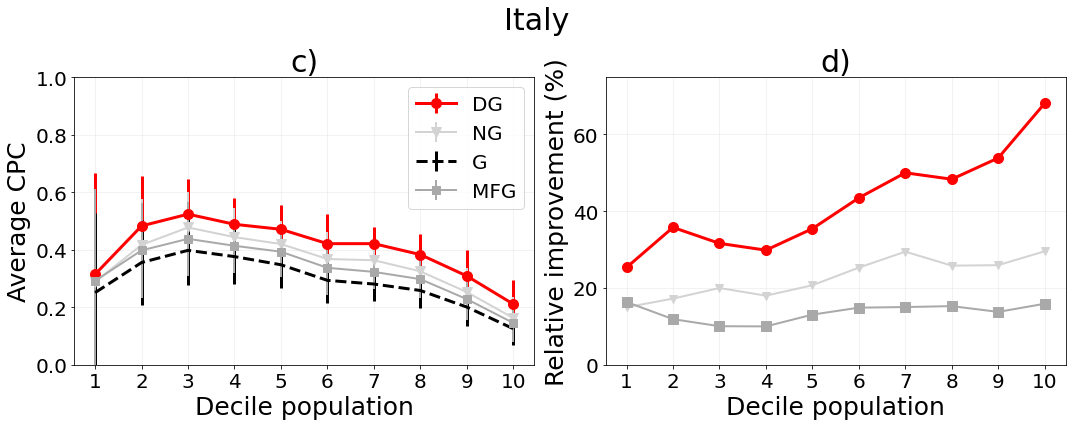

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

st = fig.suptitle(country_to_string[country], fontsize=30)

avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []

for decile in df.decile_n_oas.unique():
    df_temp = df[df.decile_n_oas == decile]

    avg_deep = df_temp.deep.mean()
    avg_original_p = df_temp.original_p.mean()
    avg_deep_p = df_temp.deep_p.mean()
    avg_original = df_temp.original.mean()

    avg_deeps.append(avg_deep)
    avg_originals_p.append(avg_original_p)
    avg_deeps_p.append(avg_deep_p)
    avg_originals.append(avg_original)

    std_deep = df_temp.deep.std()
    std_original_p = df_temp.original_p.std()
    std_deep_p = df_temp.deep_p.std()
    std_original = df_temp.original.std()

    std_deeps.append(std_deep)
    std_originals_p.append(std_original_p)
    std_deeps_p.append(std_deep_p)
    std_originals.append(std_original)

    relative_improve_original_p_deep = []
    relative_improve_original_p_deep_p = []
    relative_improve_original_p_original = []

for a, b in zip(avg_originals_p, avg_deeps):
    relative_improve_original_p_deep.append(((b - a) / a)*100)

for a, b in zip(avg_originals_p, avg_deeps_p):
    relative_improve_original_p_deep_p.append(((b - a) / a)*100)

for a, b in zip(avg_originals_p, avg_originals):
    relative_improve_original_p_original.append(((b - a) / a)*100)

# decile plots
ax = axes[0]

ax.errorbar(range(10), avg_deeps, yerr=std_deeps, marker='o',
          color=main_color, label='DG', linewidth=3, markersize=10)

ax.errorbar(range(10), avg_deeps_p, yerr=std_deeps_p, marker='v',
          color='lightgrey', label='NG', linewidth=2, markersize=10)  

ax.errorbar(range(10), avg_originals_p, yerr=std_originals_p,
          color='black', label='G', linestyle='--', linewidth=3)  


ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
          color='darkgrey', linewidth=2, 
          label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_xticks(range(10))
ax.set_xticklabels(range(1, 11))
ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc=1)

# relative improvement plot

ax = axes[1]

ax.plot(range(len(relative_improve_original_p_deep)), relative_improve_original_p_deep, color=main_color, linewidth=3, 
      marker='o', markersize=10)

ax.plot(range(len(relative_improve_original_p_deep_p)), relative_improve_original_p_deep_p, color='lightgrey', linewidth=2, 
      marker='v', markersize=8)

ax.plot(range(len(relative_improve_original_p_original)), relative_improve_original_p_original, color='darkgrey', linewidth=2, 
      marker='s', markersize=10)

ax.set_ylabel('Relative improvement (%)', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_ylim(0,max(relative_improve_original_p_deep)+max(relative_improve_original_p_deep)*0.1)
ax.tick_params(labelsize=20)
ax.set_title(country_to_subid[country][1], fontsize=30)
ax.grid(alpha=0.2)



plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('../plots/average_cpc_'+country+'.pdf')